In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from read_data import *
from model_simulations import *
from numpy import linalg as LA
from time import time
from pprint import pprint
from copy import deepcopy as copy


%matplotlib inline
%load_ext autoreload
%aimport read_data
%aimport model_simulations
%autoreload 1

## Simulation


1. Randomly infect people in each state with probability `p_inf`
    - Calculate fraction of infected people
2. Air travel the people
    - Fraction of infected air travelers is the same as origin state
    - Each person has a chance to infect every other person in the new state with probability `p_transfer`
3. In each state, either recover, kill, or remain infected the people there with probability `p_rec, p_die, p_stay`
4. Increment, or decrement, population between years (not quarters)

Totally, there are 4 parameters: `p_inf`, `p_transfer`, `p_rec`, `p_die`

Note `p_stay = 1 - p_rec - p_die`

Can make into a 3 parameter model by setting `p_stay = 0` i.e., between quarters, people either heal completely, or die.

### Goal: Find the best parameters that represent the number of deaths observed

In [100]:
data_dir = "../Data/Clean/"
deaths_fname = "deaths_NCHS_processed.csv"
population_fname = "population.csv"

states_abb_dict, states_abb_rev_dict, stats_abb_ord_list = read_US_states(data_dir + "states_abb.csv")
deaths_dict = read_deaths_data(data_dir + deaths_fname)
population_dict = read_population_dict(data_dir + population_fname)

adj_list = {}
A = {}
A[2009] = {}
A[2009][4] = read_travel_network(data_dir + "2009_Q4.csv", states_abb_dict, states_abb_rev_dict)[1]
for year in range(2010, 2019):
    A[year] = {}
    for quarter in range(1, 5):
        network_fname = str(year) + "_Q" + str(quarter) + ".csv"
        A[year][quarter] = read_travel_network(data_dir + network_fname, states_abb_dict, states_abb_rev_dict)[1]
A[2019] = {}
A[2019][1] = read_travel_network(data_dir + "2019_Q1.csv", states_abb_dict, states_abb_rev_dict)[1]

all_population = {}
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
for year in years:
    all_population[year] = []


for state,data in population_dict.items():
    for year, pop in data.items():
        all_population[year].append(pop)
        if year == 2018:
            all_population[2019].append(pop)
        
A_dict = A

In [104]:
deaths_matrix = {-1: [], 1: [], 2: [], 3: [], 4:[]}
for state, yearly_deaths_dict in deaths_dict.items():
    deaths_vector = {}
    for q in deaths_matrix:
        deaths_vector[q] = []
    for year, quarterly_deaths_dict in yearly_deaths_dict.items():
#         if year > 2012:
#             continue
        for quarter, deaths_count in quarterly_deaths_dict.items():
            deaths_vector[-1].append(deaths_count)
            deaths_vector[quarter].append(deaths_count)
    for q in deaths_matrix:
        deaths_matrix[q].append(deaths_vector[q])
        
for q in deaths_matrix:
    deaths_matrix[q] = np.array(deaths_matrix[q])
#     print(deaths_matrix[q].shape)

In [105]:
# Fix parameters of the model
P_inf = np.linspace(0.05, 0.2, num=100)
P_transfer = np.linspace(0, 1, num=100)
P_rec = np.linspace(0, 1, num=100)
p_die = 7.540044190323758e-05

sim_quarter = 1
touch_fraction = 1

x0 = np.array([P_inf[23], P_transfer[10], P_rec[33]])
Y_est = run_full_simulation(x0, A_dict, all_population, years,
                            sim_quarter=sim_quarter, touch_fraction=touch_fraction)
cost = get_cost(deaths_matrix[sim_quarter], Y_est)
print(cost)

0.0011493850286193414


### Random Walks?

In [106]:
def perturbe(x, mu=0, sigma=1e-4):
    return x + np.random.normal(mu, sigma, size=x.shape)

def isvalid(x):
    return (x <= 1).all() and (x >= 0).all()

error_tol = 1e-4
quarter = 1
touch_fraction = 0.5

x_best = np.array([0.1, 0.1, 0.99])
# x_best = np.random.uniform(0, 1, size=(3,))
print(x_best)
Y_est = run_full_simulation(x_best, A_dict, all_population, years,
                            sim_quarter=quarter, touch_fraction=touch_fraction)
error = get_cost(deaths_matrix[quarter], Y_est)
error_best = error

print("0", error)

ctr = 0
invalid_ctr = 0

while error > error_tol:
    x_i = perturbe(x_best, mu=0, sigma=1e-2)
#     x_i = x_best + np.random.normal(0, 1e-3, size=x_best.shape)
    if not isvalid(x_i):
        invalid_ctr += 1
        if invalid_ctr % 10 == 0:
            print("Invalid: ", invalid_ctr)
        continue
    Y_est = run_full_simulation(x_i, A_dict, all_population, years,
                                sim_quarter=quarter, touch_fraction=touch_fraction)
    error = get_cost(deaths_matrix[quarter], Y_est)
    ctr += 1
    if error < error_best:
        x_best = copy(x_i)
        error_best = error
        print(ctr, error)
    elif ctr % 10 == 0:
        print("Counter: ", ctr)

[0.1  0.1  0.99]
0 0.0012469581409305542
3 0.001205177354450148
4 0.0011913268361662328
8 0.0011626406520388846
9 0.001151137726763956
10 0.0011404666490784868
11 0.0011254640177490846
12 0.001121689040210102
14 0.0011182763917297219
Counter:  20
23 0.0011173814679722245
Counter:  30
40 0.0011169672137767196
41 0.001116447855534303
Counter:  50
Counter:  60
65 0.0011157753992171295
Counter:  70
Counter:  80
Counter:  90
97 0.0011157211756496713
Counter:  100
Counter:  110
Counter:  120
127 0.0011156734379823795
Counter:  130
Counter:  140


KeyboardInterrupt: 

In [107]:
quarter = 1
print(x_best)
sim_deaths = run_full_simulation(x_best, A_dict, all_population, years,
                                 sim_quarter=quarter, touch_fraction=0.8)
error = get_cost(deaths_matrix[quarter], sim_deaths)
print(error)

[0.16590685 0.18772156 0.94563735]
0.0011423277508961598


In [109]:
fraction = np.abs(deaths_matrix[quarter] - sim_deaths)# / deaths_matrix[-1]
np.mean(fraction)

662.516

In [111]:
# simulated results = sim_deaths and real data = deaths_matrix
diff = (deaths_matrix[quarter] - sim_deaths).flatten()
print(np.mean(diff))
print(np.std(diff))

88.832
998.8885922744338


In [112]:
stid = 0

for stid in range(50):
    norm_coeff = LA.norm(deaths_matrix[quarter][stid]) * sim_deaths[stid].shape[0]
    print(stid, LA.norm(sim_deaths[stid] - deaths_matrix[quarter][stid]) / norm_coeff)
    
# print(sim_deaths[stid])
# print(deaths_matrix[quarter][stid])

0 1.19543532895225
1 0.08732614437090064
2 0.05293166766440453
3 0.05382413196813852
4 0.012315819119353685
5 0.034036272623015354
6 0.035515148813612674
7 0.016054105700459762
8 0.015735356217525025
9 0.026011313247132826
10 0.027058988050295794
11 0.060863679191468775
12 0.7480118686677176
13 0.05243658665232812
14 0.06308507299239856
15 0.027264569897250637
16 0.03725979327326261
17 0.01821906339518552
18 0.08503166364618514
19 0.011483944878121191
20 0.25884089457576615
21 0.014780693870227722
22 0.016271268334330298
23 0.0634553732890666
24 0.06271247932469537
25 0.017399784525390163
26 0.085141890017088
27 0.21118766151067514
28 0.045257133426421244
29 0.4520020718081549
30 0.07470013904260991
31 0.6710940033565507
32 0.24820926942275287
33 0.09682607458924461
34 0.023628043404767263
35 0.036805747332327006
36 0.014918692058958022
37 0.023760462449084214
38 0.03533283559970552
39 0.020026490999927045
40 0.036883404895820454
41 0.030616897652329233
42 0.01642760085593016
43 0.0393

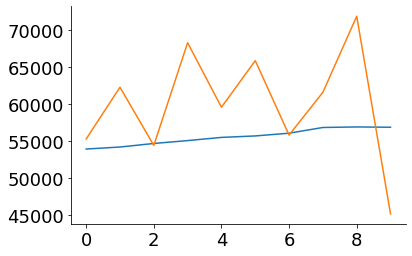

In [113]:
plt.plot(sim_deaths.sum(axis=0))
plt.plot(deaths_matrix[1].sum(axis=0))

In [114]:
sim_deaths.sum(axis=0)

array([53967, 54239, 54719, 55109, 55538, 55737, 56106, 56880, 56953,
       56911])

In [115]:
deaths_matrix[1].sum(axis=0)

array([55328., 62320., 54454., 68337., 59616., 65912., 55858., 61637.,
       71918., 45195.])

In [116]:
A_dict[2009][4]

array([[0.000e+00, 0.000e+00, 9.670e+03, ..., 0.000e+00, 5.000e+01,
        0.000e+00],
       [1.000e+01, 0.000e+00, 1.225e+04, ..., 0.000e+00, 3.000e+01,
        0.000e+00],
       [9.590e+03, 1.175e+04, 0.000e+00, ..., 0.000e+00, 4.018e+04,
        4.000e+01],
       ...,
       [1.000e+01, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.000e+01,
        0.000e+00],
       [1.000e+01, 0.000e+00, 3.756e+04, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 5.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

need beautiful plots!

Tasks

- Get convergence plots
- Do for each season (quarter)
- Learn parameters from first five years and predict the rest
- Repeat with no travel and compare results
- Why are some states absolutely terrible?

In [81]:
deceased_df = pd.DataFrame.from_records([[i, j] + num_deceased[i][j] for i in num_deceased for j in num_deceased[i]])
deceased_df.to_csv('deceased_df_real_data_3.csv')

NameError: name 'num_deceased' is not defined

### Real Data No Travel

In [ ]:
sim_time = time()

states = []
year_0 = 2009
for state_id in range(50):
    state = State(all_population[year_0][state_id])
    state.num_infected += np.random.binomial(state.num_total, p_inf)
    states.append(state)
    
# Propagate infection
num_deceased_no_travel = {}

# For each year:
for year in years:
    iter_time = time()
    num_deceased_no_travel[year] = {}
    # For each quarter:
    for quarter in range(1, 5):
        if year == 2009 and quarter != 4:
            continue
        if year == 2019 and quarter != 1:
            continue
        # 1. travel and infect
        # 2. Recover
        # 3. Remove deceased and store it
        # 4. Randomly infect
#         states = travel_and_infect_kernel(A_dict[year][quarter], states, p_transfer)
        states = recover_kernel(states, SIR)
        states, dead_peeps = remove_deceased_kernel(states)
        num_deceased_no_travel[year][quarter] = dead_peeps
        states = random_infection_kernel(states, p_inf)
    
    # Inject population
    try:
        pop_vec = inject_population_kernel(states, all_population[year+1])
    except KeyError:
        # We are at the end of our data
        pass
    
    iter_time = time() - iter_time
    print("Elapsed time for {}: {:.3f} s".format(year, iter_time))

sim_time = time() - sim_time
print("Total elapsed time for simulation: {:.3f} s".format(sim_time))

In [ ]:
deceased_no_travel_df = pd.DataFrame.from_records([[i, j] + num_deceased_no_travel[i][j] for i in num_deceased_no_travel for j in num_deceased_no_travel[i]])
deceased_no_travel_df.to_csv('deceased_df_no_travel_real_data_3.csv')


# Centrality Plots

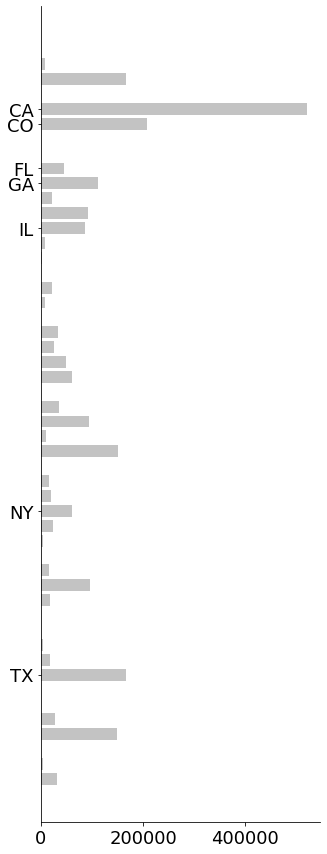

In [156]:
mt = 43
mt_travel = np.zeros((50,))

ctr = 0
for year, quarterly_travel in A_dict.items():
    for quarter, travel in quarterly_travel.items():
        mt_travel += travel[mt]
        ctr += 1
mt_travel /= ctr

plt.figure(figsize=(5, 15))
plt.barh(range(50), mt_travel, color="dimgrey", alpha=0.4)

state_ids = [4, 5, 8, 9, 12, 31, 42]
state_abbs = [stats_abb_ord_list[abb_id] for abb_id in state_ids]

plt.yticks(state_ids, state_abbs)

plt.gca().invert_yaxis()
# plt.xticks([])
plt.show()

In [149]:
closeness_centrality = np.zeros((50,))
ctr = 0
for year, quarterly_travel in A_dict.items():
    for quarter, travel in quarterly_travel.items():
        closeness_centrality += travel.sum(axis=1)
        ctr += 1
closeness_centrality /= ctr

In [132]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)

### Spreading centrality

In [154]:
num_deaths = np.zeros((50,))

for ctrl_state_id in range(50):

    A_spread = copy(A_dict)
    for q in A_spread:
        for A in A_spread[q]:
            tmp = np.zeros((50, 50))
            tmp[ctrl_state_id,: ] = A_spread[q][A][ctrl_state_id,: ]
            A_spread[q][A] = copy(tmp)

    p_vec = [0.07278656, 0.1854208, 0.96283932]
    deaths = run_full_simulation(p_vec, A_spread, all_population, years, sim_quarter=-1)
    num_deaths[ctrl_state_id] = np.sum(deaths) /deaths.shape[1]

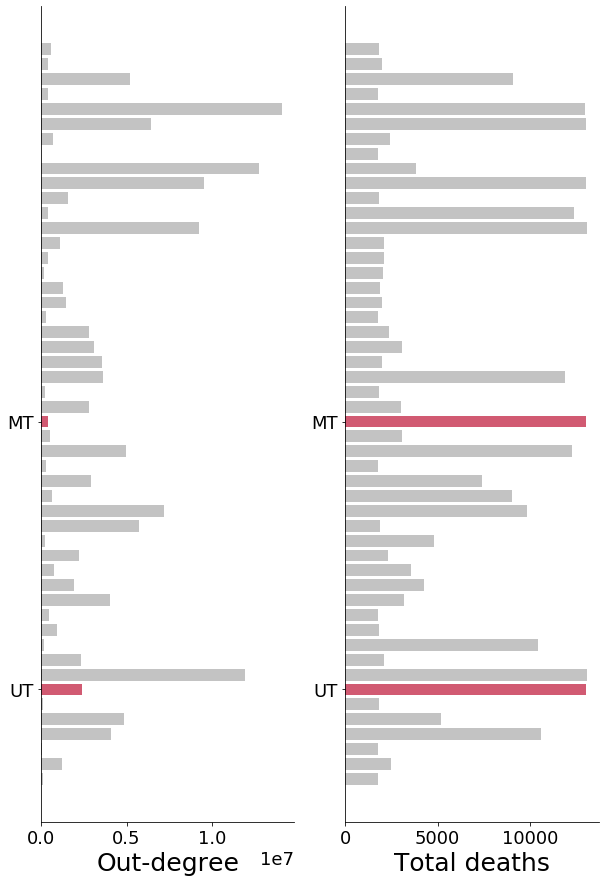

In [161]:
fig, ax = plt.subplots(1, 2, figsize=(10, 15))

ax[0].barh(range(50), closeness_centrality, color="dimgrey", alpha=0.4)

# state_ids = [4, 5, 8, 9, 12, 25, 31, 42, 43, 46]
state_ids = [25, 43]
state_abbs = [stats_abb_ord_list[abb_id] for abb_id in state_ids]

ax[0].barh(state_ids, closeness_centrality[state_ids], color="crimson", alpha=0.6)

ax[0].set_yticks(state_ids)
ax[0].set_yticklabels(state_abbs)

ax[0].invert_yaxis()
ax[0].set_xlabel("Out-degree", fontsize=25)


ax[1].barh(range(50), num_deaths, color="dimgrey", alpha=0.4)

# state_ids = list(np.argsort(num_deaths)[::-1][:6]) + [4, 8, 25, 31, 46]
state_abbs = [stats_abb_ord_list[abb_id] for abb_id in state_ids]

ax[1].barh(state_ids, num_deaths[state_ids], color="crimson", alpha=0.6)

ax[1].set_yticks(state_ids)
ax[1].set_yticklabels(state_abbs)
# plt.xticks([0, 5e5, 1e6, 1.5e6], ["0", "0.5e6", "1e6", "1.5e6"])

ax[1].set_xlabel("Total deaths", fontsize=25)

ax[1].invert_yaxis()

# plt.savefig("../figures/mt-ut-compare-centralities.PNG", dpi=200, bbox_inches="tight")

plt.show()

In [142]:
np.argsort(num_deaths)[::-1]

array([43, 42,  4,  9, 12,  5, 25, 11, 27, 22, 46, 40, 31,  2, 30, 29, 45,
       33, 36,  8, 35, 37, 20, 26, 24, 48,  6, 19, 34, 41, 14, 13, 15, 17,
       21,  1, 16, 32, 23,  0, 10,  3, 39, 44, 38, 47,  7, 28, 49, 18],
      dtype=int64)